In [247]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [82]:
def create_clarity_cat(clarity):
    if clarity == 'FL':
        c_cat = 1
    elif clarity == 'IF':
        c_cat = 2
    elif clarity == 'VVS1' or clarity == 'VVS2':
        c_cat = 3
    elif clarity == 'VS1' or clarity == 'VS2':
        c_cat = 4
    elif clarity == 'SI1' or clarity == 'SI2':
        c_cat = 5
    elif clarity == 'I1' or clarity == 'I2' or clarity == 'I3':
        c_cat = 6
    else:
        c_cat = 0
    return c_cat

def create_color_cat(color):
    #.encode('ascii')
    #print(type(color))
    #isinstance(a, object)
    if not isinstance(color,float):
        if color == 'D':
            color_cat = 1
        elif color == 'E':
            color_cat = 2
        elif color == 'F':
            color_cat = 3
        elif ord(color) >= ord("G") or ord(color) <= ord("H"):
            color_cat = 4
        elif ord(color) >= ord("I"):
            color_cat = 5
        else:
            color_cat = 0
        return color_cat
    return 0

    
def create_cut_cat(cut):
    if cut == 'Poor':
        cut_cat = 1
    elif cut == 'Fair':
        cut_cat = 2
    elif cut == 'Good':
        cut_cat = 3
    elif cut == 'Very Good':
        cut_cat = 4
    elif cut == 'Ideal':
        cut_cat = 5
    elif cut == 'Signature-Ideal':
        cut_cat = 6
    else: 
        cut_cat = 0
    return cut_cat

def create_PS_cat(polish):
    if polish == 'G':
        polish_cat = 1
    elif polish == 'VG':
        polish_cat = 2
    elif polish == 'EX':
        polish_cat = 3
    elif polish == 'ID':
        polish_cat = 4
    else:
        polish_cat = 0
    return polish_cat


def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in x_valid.columns:
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

def linear_regression(fts, target):
    """
    Линейная регрессия.

    Parameters
    ----------
    fts: набор полей для обучения модели 
    target: str
        Название целевого поля.
    
    Returns
    -------
    
    """
    train_scaled = train.loc[:,fts]
    valid_scaled = valid.loc[:,fts]
    
    
    lr = LinearRegression()
    lr.fit(train_scaled, train[target])
    pred = lr.predict(train_scaled)
    print("метрика R2 для тренировочного набора train:", r2(train[target], pred))
    pred_valid = lr.predict(valid_scaled.loc[:,fts])
    print("метрика R2 для валидационного набора valid:", r2(valid[target], pred_valid))
    mse = MSE(valid[target],pred_valid)
    print("метрика MSE:", mse)    
    return lr

def knn(fts, target):
    """
    Линейная регрессия.

    Parameters
    ----------
    fts: набор полей для обучения модели 
    target: str
        Название целевого поля.
    
    Returns
    -------
    
    """
    train_scaled = train.loc[:,fts]
    valid_scaled = valid.loc[:,fts]
    knn = KNN(n_neighbors=2,weights='distance')
    knn.fit(train_scaled, train[target])
    pred = knn.predict(train_scaled)
    pred_valid = knn.predict(valid_scaled)
    print("метрика R2 для тренировочного набора train:", r2(train[target], pred))
    print("метрика R2 для валидационного набора valid:", r2(valid[target], pred_valid))
    mse = MSE(valid[target],pred_valid)
    print("метрика MSE:", mse)    
    return knn

In [200]:
def create_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy() 
    X['Color'] = X['Color'].fillna(X['Color'].mode())
    X['Symmetry'] = X['Symmetry'].fillna(X['Symmetry'].mode())
#Добавление новой категориальной переменной - возрастная категория
    X["Cut_cat"] = X["Cut"].apply(lambda x: create_cut_cat(x))
    X["Color_cat"] = X["Color"].apply(lambda x: create_color_cat(x))
    X["Clarity_cat"] = X["Clarity"].apply(lambda x: create_clarity_cat(x))
    X["Polish_cat"] = X["Polish"].apply(lambda x: create_PS_cat(x))
    X["Symmetry_cat"] = X["Symmetry"].apply(lambda x: create_PS_cat(x))
        
    X[['Clarity_0','Clarity_1','Clarity_2','Clarity_3','Clarity_4','Clarity_5']] = pd.get_dummies(X["Clarity_cat"])
    X[['Color_0','Color_1','Color_2','Color_3','Color_4']] = pd.get_dummies(X["Color_cat"])
    X[['Cut_0','Cut_2','Cut_3','Cut_4','Cut_5','Cut_6']] = pd.get_dummies(X["Clarity_cat"])
    
#    data[['Cash','Credit Card']] = pd.get_dummies(data["name_contract_type"])
    
#    X = X[["ID","Carat Weight", "Cut_cat", "Color_cat", "Clarity_cat", "Polish_cat", "Symmetry_cat", "Price"]]
    X = X[["ID","Carat Weight",'Clarity_cat','Clarity_1','Clarity_2','Clarity_3','Clarity_4','Clarity_5','Color_cat','Color_1','Color_2','Color_3','Color_4','Cut_cat','Cut_2','Cut_3','Cut_4','Cut_5','Cut_6',"Price"]]
    
    return X

In [201]:
df = pd.read_excel("Data\Sarah gets a diamond data.xls")

In [202]:
df.columns = list(df.iloc[1,:])

In [203]:
df = df.iloc[2:,:]

In [204]:
df

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
2,1,1.1,Ideal,H,SI1,VG,EX,GIA,5169
3,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
4,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183
5,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370
6,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...,...
5997,5996,1.03,Ideal,D,SI1,EX,EX,GIA,NaN
5998,5997,1,Very Good,D,SI1,VG,VG,GIA,NaN
5999,5998,1.02,Ideal,D,SI1,EX,EX,GIA,NaN
6000,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,NaN


In [205]:
df.describe()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
count,6000,6000.00,6000,5999,6000,6000,5999,6000,4500.0
unique,6000,198.00,8,7,8,5,5,2,3791.0
top,6000,1.01,Ideal,G,SI1,EX,VG,GIA,5534.0
freq,1,448.00,2479,1501,2059,2425,2416,5266,5.0


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 2 to 6001
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            6000 non-null   object
 1   Carat Weight  6000 non-null   object
 2   Cut           6000 non-null   object
 3   Color         5999 non-null   object
 4   Clarity       6000 non-null   object
 5   Polish        6000 non-null   object
 6   Symmetry      5999 non-null   object
 7   Report        6000 non-null   object
 8   Price         4500 non-null   object
dtypes: object(9)
memory usage: 422.0+ KB


In [207]:
df['Color'].unique()

array(['H', 'E', 'G', 'D', 'F', 'I', nan, '-'], dtype=object)

In [208]:
df['Symmetry'].unique()

array(['EX', 'ID', 'VG', 'G', '  ', nan], dtype=object)

In [209]:
df['Polish'].unique()

array(['VG', 'ID', 'EX', 'G', 'НД'], dtype=object)

In [210]:
df_new = create_features(df)

In [211]:
df_new

,ID,Carat Weight,Clarity_cat,Clarity_1,Clarity_2,Clarity_3,Clarity_4,Clarity_5,Color_cat,Color_1,Color_2,Color_3,Color_4,Cut_cat,Cut_2,Cut_3,Cut_4,Cut_5,Cut_6,Price
2,1,1.1,5,0,0,0,0,1,4,0,0,0,1,5,0,0,0,0,1,5169
3,2,0.83,4,0,0,0,1,0,4,0,0,0,1,5,0,0,0,1,0,3470
4,3,0.85,5,0,0,0,0,1,4,0,0,0,1,5,0,0,0,0,1,3183
5,4,0.91,5,0,0,0,0,1,2,0,1,0,0,5,0,0,0,0,1,4370
6,5,0.83,5,0,0,0,0,1,4,0,0,0,1,5,0,0,0,0,1,3171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,5996,1.03,5,0,0,0,0,1,1,1,0,0,0,5,0,0,0,0,1,NaN
5998,5997,1,5,0,0,0,0,1,1,1,0,0,0,4,0,0,0,0,1,NaN
5999,5998,1.02,5,0,0,0,0,1,1,1,0,0,0,5,0,0,0,0,1,NaN
6000,5999,1.27,4,0,0,0,1,0,4,0,0,0,1,6,0,0,0,1,0,NaN


Исследование данных

Исследование распределения по чистоте в данном наборе бриллиантов  

In [212]:
print('1 - FL')
print('2 - IF')
print('3 - VVS1/VVS2')
print('4 - VS1/VS2')
print('5 - SI1/SI2')

1 - FL
2 - IF
3 - VVS1/VVS2
4 - VS1/VS2
5 - SI1/SI2


In [213]:
df_new['Clarity_cat'].value_counts(normalize=True)

4    0.461000
5    0.343167
3    0.158500
2    0.036500
1    0.000667
0    0.000167
Name: Clarity_cat, dtype: float64

In [214]:
df_Clarity = df_new.groupby('Clarity_cat')['ID'].count().reset_index().sort_values('Clarity_cat') 
df_Clarity

,Clarity_cat,ID
0,0,1
1,1,4
2,2,219
3,3,951
4,4,2766
5,5,2059


Text(0, 0.5, 'количество бриллиантов')

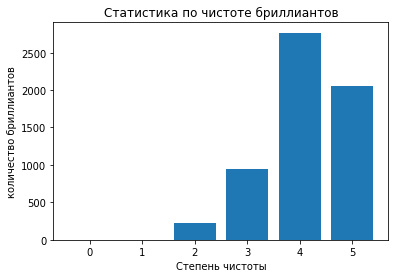

In [215]:
plt.bar(df_Clarity['Clarity_cat'], df_Clarity['ID'])
plt.title('Статистика по чистоте бриллиантов')
plt.xlabel('Степень чистоты')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [216]:
serie = df_new.groupby('Clarity_cat')['ID'].count()
serie

Clarity_cat
0       1
1       4
2     219
3     951
4    2766
5    2059
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по чистоте бриллиантов')

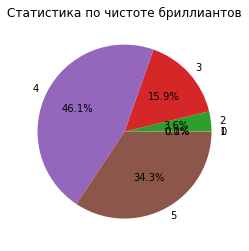

In [217]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по чистоте бриллиантов')

Исследование распределения по цвету в данном наборе бриллиантов

In [218]:
print('1 - D (совершенно бесцветные)')
print('2 - E')
print('3 - F')
print('4 - G-H')
print('5 - I-J')

1 - D (совершенно бесцветные)
2 - E
3 - F
4 - G-H
5 - I-J


In [219]:
df_new['Color_cat'].value_counts(normalize=True)

4    0.591333
3    0.168667
2    0.129667
1    0.110167
0    0.000167
Name: Color_cat, dtype: float64

In [220]:
df_Color = df_new.groupby('Color_cat')['ID'].count().reset_index().sort_values('Color_cat') 
df_Color

,Color_cat,ID
0,0,1
1,1,661
2,2,778
3,3,1012
4,4,3548


Text(0, 0.5, 'количество бриллиантов')

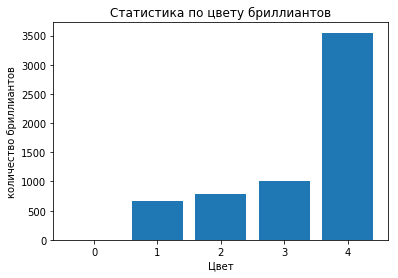

In [221]:
plt.bar(df_Color['Color_cat'], df_Color['ID'])
plt.title('Статистика по цвету бриллиантов')
plt.xlabel('Цвет')
plt.ylabel('количество бриллиантов')
#plt.xticks(rotation=45)

In [222]:
serie = df_new.groupby('Color_cat')['ID'].count()
serie

Color_cat
0       1
1     661
2     778
3    1012
4    3548
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по цвету бриллиантов')

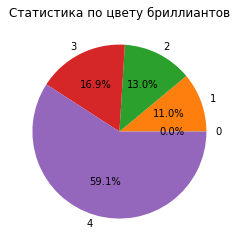

In [223]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по цвету бриллиантов')

Исследование распределения по огранке в данном наборе бриллиантов

In [228]:
print('1 - Poor')
print('2 - Fair')
print('3 - Good')
print('4 - Very Good')
print('5 - Ideal')
print('6 - Signature-Ideal')

1 - Poor
2 - Fair
3 - Good
4 - Very Good
5 - Ideal
6 - Signature-Ideal


In [229]:
df_new['Cut_cat'].value_counts(normalize=True)

5    0.413167
4    0.404667
3    0.117833
6    0.042167
2    0.021500
0    0.000667
Name: Cut_cat, dtype: float64

In [232]:
df_Cut = df_new.groupby('Cut_cat')['ID'].count().reset_index().sort_values('Cut_cat') 
df_Cut

,Cut_cat,ID
0,0,4
1,2,129
2,3,707
3,4,2428
4,5,2479
5,6,253


In [234]:
serie = df_new.groupby('Cut_cat')['ID'].count()
serie

Cut_cat
0       4
2     129
3     707
4    2428
5    2479
6     253
Name: ID, dtype: int64

Text(0.5, 1.0, 'Статистика по огранке бриллиантов')

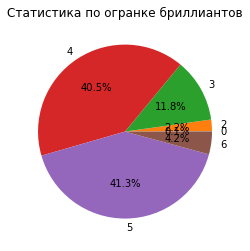

In [235]:
plt.pie(serie, labels=serie.index, autopct='%1.1f%%')
plt.title('Статистика по огранке бриллиантов')

Исследование зависимости стоимости бриллианта от чистоты 

In [240]:
train = df_new[~df_new['Price'].isnull()]

In [241]:
train['int_price'] = train['Price'].apply(lambda x: int(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [242]:
print('1 - FL')
print('2 - IF')
print('3 - VVS1/VVS2')
print('4 - VS1/VS2')
print('5 - SI1/SI2')

1 - FL
2 - IF
3 - VVS1/VVS2
4 - VS1/VS2
5 - SI1/SI2


In [243]:
df_Clarity = train.groupby('Clarity_cat')['int_price'].median().reset_index().sort_values('Clarity_cat') 
df_Clarity

,Clarity_cat,int_price
0,1,81399.0
1,2,11930.0
2,3,10470.0
3,4,8339.0
4,5,5409.5


Text(0, 0.5, 'стоимость бриллиантов')

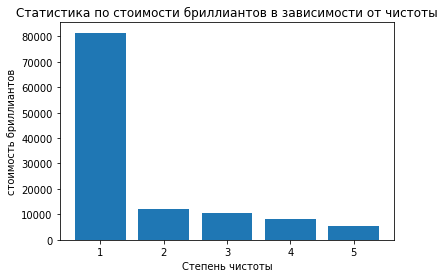

In [244]:
plt.bar(df_Clarity['Clarity_cat'], df_Clarity['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от чистоты')
plt.xlabel('Степень чистоты')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: наблюдается очень четкая зависимость цены от чистоты бриллианта.

Исследование зависимости стоимости бриллианта от цвета 

In [245]:
print('1 - D (совершенно бесцветные)')
print('2 - E')
print('3 - F')
print('4 - G-H')
print('5 - I-J')

1 - D (совершенно бесцветные)
2 - E
3 - F
4 - G-H
5 - I-J


In [246]:
df_Color = train.groupby('Color_cat')['int_price'].median().reset_index() 
df_Color

,Color_cat,int_price
0,0,7698.0
1,1,7657.5
2,2,7178.0
3,3,8628.0
4,4,8093.0
5,5,6689.5


Text(0, 0.5, 'стоимость бриллиантов')

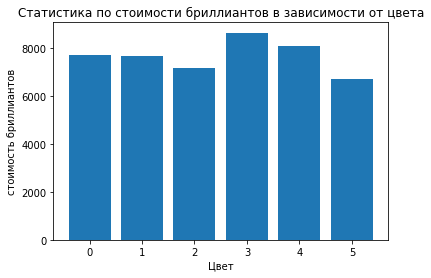

In [247]:
plt.bar(df_Color['Color_cat'], df_Color['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от цвета')
plt.xlabel('Цвет')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: зависимость цены от цвета бриллианта не очень четкая.

Исследование зависимости стоимости бриллианта от огранки 

In [248]:
print('1 - Poor')
print('2 - Fair')
print('3 - Good')
print('4 - Very Good')
print('5 - Ideal')
print('6 - Signature-Ideal')

1 - Poor
2 - Fair
3 - Good
4 - Very Good
5 - Ideal
6 - Signature-Ideal


In [249]:
df_Cut = train.groupby('Cut_cat')['int_price'].median().reset_index() 
df_Cut

,Cut_cat,int_price
0,0,14154.0
1,2,4771.0
2,3,6063.5
3,4,7079.5
4,5,9221.5
5,6,9434.0


Text(0, 0.5, 'стоимость бриллиантов')

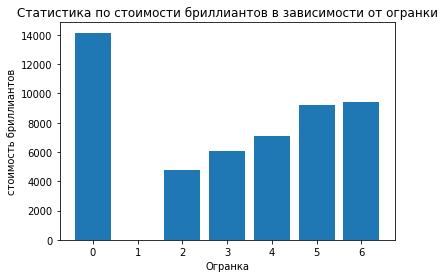

In [250]:
plt.bar(df_Cut['Cut_cat'], df_Cut['int_price'])
plt.title('Статистика по стоимости бриллиантов в зависимости от огранки')
plt.xlabel('Огранка')
plt.ylabel('стоимость бриллиантов')
#plt.xticks(rotation=45)

Вывод: зависимость цены от цвета бриллианта четкая.

Исследование распределений весов камней в тренировочном и тестовом наборах 

In [251]:
def my_basic_research(df, column = "volume"):
    print("среднее: ", df[column].mean())
    print("средне-квадратичное отклонение: ", df[column].std())
    print("медиана: ", df[column].median())    
    print("50 перцентиль: ", np.percentile(df[column], 50))
    print("75 перцентиль: ", np.percentile(df[column], 75))
    print("99 перцентиль: ", np.percentile(df[column], 99))
    print("мода: ", df[column].mode())
    print("Самое популярное значение метрики, топ 1")
    print(df[column].value_counts().nlargest(1))
    print("------------------------------------")
    

In [252]:
my_basic_research(train,'Carat Weight')

среднее:  4.775571111111034
средне-квадратичное отклонение:  170.11453792002348
медиана:  1.13
50 перцентиль:  1.13
75 перцентиль:  1.58
99 перцентиль:  2.520100000000002
мода:  0    1.01
dtype: object
Самое популярное значение метрики, топ 1
1.01    347
Name: Carat Weight, dtype: int64
------------------------------------


Медиана и среднее сильно различаются, значит много выбросов.

In [253]:
my_basic_research(df_new[df_new['Price'].isnull()],'Carat Weight')

среднее:  1.3441666666666636
средне-квадратичное отклонение:  0.47755678113535477
медиана:  1.14
50 перцентиль:  1.14
75 перцентиль:  1.62
99 перцентиль:  2.5101
мода:  0    1.01
dtype: object
Самое популярное значение метрики, топ 1
1.01    101
Name: Carat Weight, dtype: int64
------------------------------------


В тренировочном и тестовом наборе медианы веса камней почти совпадают. В тестовом наборе меньше выбросов ('экстремально больших весов).

Исследование зависимости стоимости бриллианта от веса в тренировочном наборе

In [238]:
train_99procentile = np.percentile(train['Carat Weight'], 99)
train_99procentile

2.529899999999998

In [239]:
#train['int_Carat Weight'] = train['Carat Weight'] * 100
#train['int_Carat Weight'] = train['int_Carat Weight'].apply(lambda x: int(x))
serie = train[train['Carat Weight'] < train_99procentile].sort_values('Carat Weight').set_index('Carat Weight')['Price'] 
serie

Carat Weight
0.75     3005
0.75     3365
0.75     2923
0.75     3679
0.75     2782
        ...  
2.51    34361
2.51    29835
2.51    34314
2.51    24351
2.52    44973
Name: Price, Length: 2179, dtype: object

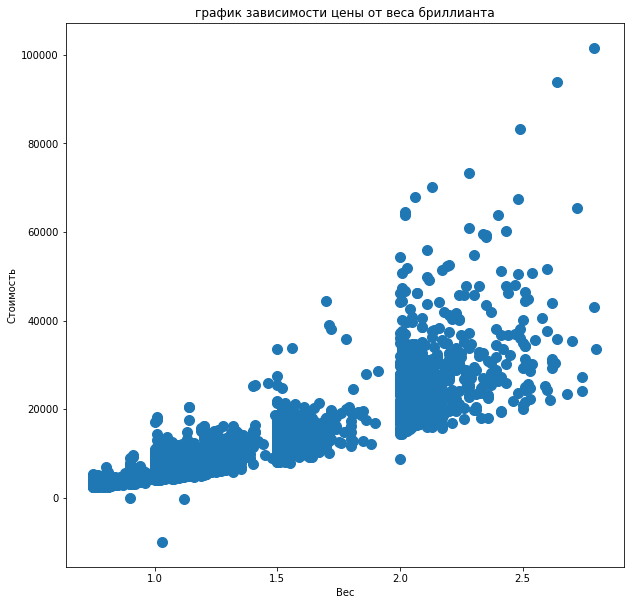

In [333]:
#на графике лучше вывести и модельные и реальные показатели одновременно
#fig, ax = plt.subplots(figsize=(12,6))
#ax.plot(serie, label='изменение стоимости с увеличением веса')

#ax.set_title('график зависимости цены от веса бриллианта')
#ax.set_xlabel('Вес')
#ax.set_ylabel('Стоимость')
#ax.set_xticks(list(range(data['Year'].min(), data['Year'].max(), 5)) + [data['Year'].max()])
#ax.legend()

#plt.show()

fig = plt.figure(figsize=(10, 10)) # создаем картинку
ax = plt.axes()
ax.set_title('график зависимости цены от веса бриллианта')
ax.set_xlabel('Вес')
ax.set_ylabel('Стоимость')
# помещаем точки на график
ax.scatter(train['Carat Weight'], train["Price"], s=100)

# отображаем картинку
plt.show()

Вывод: в целом с увеличением веса растет стоимость бриллианта. Наблюдается устойчивый восходящий тренд, но с сильными помехами-флуктуациями.

Гистограмма распределения весов камней

In [295]:
train['int_Carat Weight'] = train['Carat Weight'] * 100
train['int_Carat Weight'] = train['int_Carat Weight'].apply(lambda x: int(x))

([<matplotlib.axis.XTick at 0x622c34b748>,
 <a list of 11 Text xticklabel objects>)

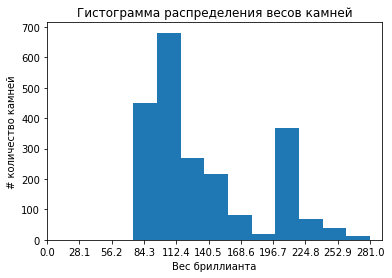

In [268]:
### YOUR CODE HERE ###
serie = train['int_Carat Weight']
max_ = max(serie)
#max_ = max(train[train['Carat Weight'] < train_99procentile]['int_Carat Weight'])

plt.hist(serie, bins=10)
plt.title("Гистограмма распределения весов камней")
plt.xlabel('Вес бриллианта')
plt.ylabel('# количество камней')

bin_width = max_ / 10
x_range = [i*bin_width for i in range(11)]
plt.xticks(x_range)

Text(0.5, 1.0, 'Гистограмма распределения весов камней')

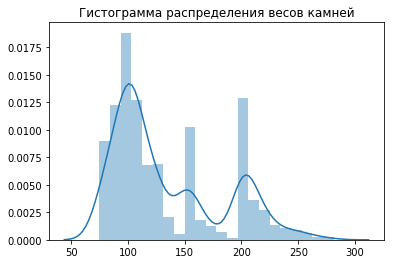

In [281]:
# При помощи seaborn
import seaborn as sns
v = train[['int_Carat Weight']]
sns.distplot(v)
plt.title("Гистограмма распределения весов камней")

Text(0.5, 1.0, 'Гистограмма распределения весов камней')

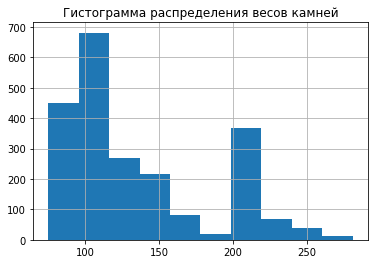

In [282]:
# При помощи pandas
v.hist(bins = 10)
plt.title("Гистограмма распределения весов камней")

Вывод: на гистограмме заметны 3 вершины (колокола). Можно разбить на 3 кластера.  

Гистограмма распределения стоимости камней

In [294]:
train['int_price'] = train['Price'].apply(lambda x: int(x))

([<matplotlib.axis.XTick at 0x6228904630>,
 <a list of 11 Text xticklabel objects>)

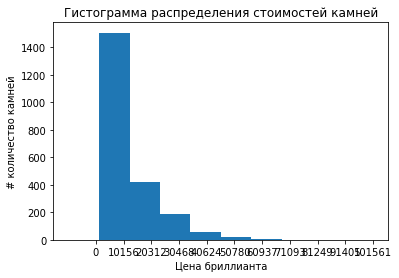

In [276]:
### YOUR CODE HERE ###
serie = train['int_price']
max_ = max(serie)
#max_ = max(train[train['Carat Weight'] < train_99procentile]['int_Carat Weight'])

plt.hist(serie, bins=10)
plt.title("Гистограмма распределения стоимостей камней")
plt.xlabel('Цена бриллианта')
plt.ylabel('# количество камней')

bin_width = max_ / 10
x_range = [i*bin_width for i in range(11)]
plt.xticks(x_range)

Text(0.5, 1.0, 'Гистограмма распределения стоимостей камней')

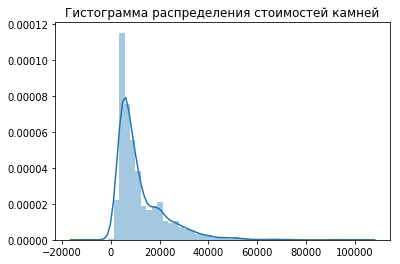

In [278]:
# При помощи seaborn
import seaborn as sns
v = train[['int_price']]
sns.distplot(v)
plt.title("Гистограмма распределения стоимостей камней")

Text(0.5, 1.0, 'Гистограмма распределения стоимостей камней')

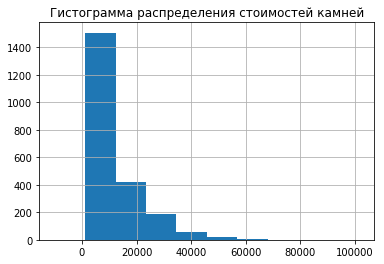

In [279]:
# При помощи pandas
v.hist(bins = 10)
plt.title("Гистограмма распределения стоимостей камней")

Вывод: на гистограмме видно, что дешовых камней значительно больше. 

Построение модели машинного обучения

In [283]:
test = df_new[df_new['Price'].isnull()]

In [284]:
#train = df_new[~df_new['Price'].isnull()]

In [297]:
print(len(train))
print(len(test))

4497
1500


In [298]:
max_carat_weight = max(test['Carat Weight'])

In [299]:
train = train[train['Carat Weight'] <= max_carat_weight]

Анализ и заполнение пропусков

In [300]:
len(train)

4497

In [301]:
train.isnull().sum()

ID                  0
Carat Weight        0
Clarity_cat         0
Clarity_1           0
Clarity_2           0
Clarity_3           0
Clarity_4           0
Clarity_5           0
Color_cat           0
Color_1             0
Color_2             0
Color_3             0
Color_4             0
Cut_cat             0
Cut_2               0
Cut_3               0
Cut_4               0
Cut_5               0
Cut_6               0
Price               0
int_price           0
int_Carat Weight    0
dtype: int64

Вычисление кореляций

In [302]:
train.columns

Index(['ID', 'Carat Weight', 'Clarity_cat', 'Clarity_1', 'Clarity_2',
       'Clarity_3', 'Clarity_4', 'Clarity_5', 'Color_cat', 'Color_1',
       'Color_2', 'Color_3', 'Color_4', 'Cut_cat', 'Cut_2', 'Cut_3', 'Cut_4',
       'Cut_5', 'Cut_6', 'Price', 'int_price', 'int_Carat Weight'],
      dtype='object')

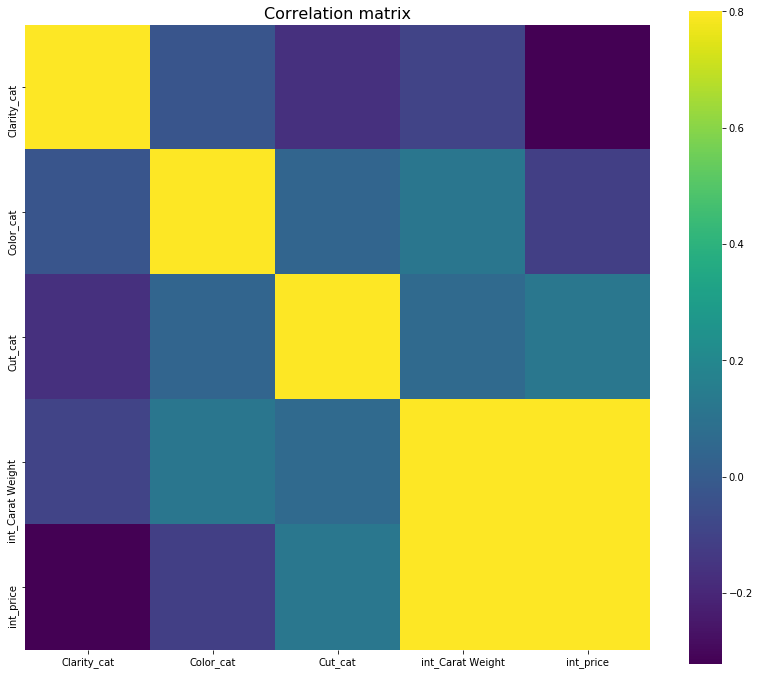

In [303]:
correlation = train[['Clarity_cat', 'Color_cat', 'Cut_cat', 'int_Carat Weight', 'int_price']].corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation matrix", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [305]:
print("Correlation of Numeric Features with Target")
correlation = train[['Clarity_cat', 'Color_cat', 'Cut_cat', 'int_Carat Weight', 'int_price']].corr()
corr_with_target1 = abs(correlation["int_price"]).sort_values(ascending = False)
corr_with_target1

Correlation of Numeric Features with Target


int_price           1.000000
int_Carat Weight    0.855046
Clarity_cat         0.321129
Cut_cat             0.122547
Color_cat           0.111915
Name: int_price, dtype: float64

Вывод: самая большая ЛИНЕЙНАЯ кореляция между весом и ценой.  

In [306]:
train, valid = train_test_split(train, test_size=0.3, random_state=42)

In [307]:
#стандартизация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train['Carat Weight2'] = scaler.fit_transform(train[['Carat Weight']])
valid['Carat Weight2'] = scaler.transform(valid[['Carat Weight']])

test['Carat Weight2'] = scaler.transform(test[['Carat Weight']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [340]:
#набор полей для модели
fts_one_hot_encoding = ["Carat Weight2", 'Clarity_1','Clarity_2','Clarity_3','Clarity_4','Clarity_5','Color_1','Color_2','Color_3','Color_4','Cut_2','Cut_3','Cut_4','Cut_5','Cut_6']
fts_order_encoding = ["Carat Weight2",'Clarity_1','Color_cat','Cut_cat']


target =  "Price"

масштабирование веса

линейная регрессия

In [344]:
lr1 = linear_regression(fts_one_hot_encoding, target)

метрика R2 для тренировочного набора train: 0.8398862667569258
метрика R2 для валидационного набора valid: 0.8430721182882805
метрика MSE: 16143300.825185852


In [345]:
fts_one_hot_encoding

['Carat Weight2',
 'Clarity_1',
 'Clarity_2',
 'Clarity_3',
 'Clarity_4',
 'Clarity_5',
 'Color_1',
 'Color_2',
 'Color_3',
 'Color_4',
 'Cut_2',
 'Cut_3',
 'Cut_4',
 'Cut_5',
 'Cut_6']

In [346]:
# вытаскиваем нужные коэффициенты
lr1.coef_

array([ 8.64693735e+03,  3.45843249e+16,  2.24333064e+17, -2.38896977e+16,
        3.71025682e+16,  2.62879962e+16,  2.49200000e+03, -5.70000000e+01,
       -6.92000000e+02, -3.61600000e+03,  3.51042719e+16, -1.54644467e+17,
        9.35782946e+16,  3.25860286e+16,  4.34006006e+16])

In [347]:
coef = pd.DataFrame({'параметры': fts_one_hot_encoding, 'веса': lr1.coef_}) 

In [348]:
coef

,параметры,веса
0,Carat Weight2,8.646937e+03
1,Clarity_1,3.458432e+16
2,Clarity_2,2.243331e+17
3,Clarity_3,-2.388970e+16
4,Clarity_4,3.710257e+16
5,Clarity_5,2.628800e+16
6,Color_1,2.492000e+03
7,Color_2,-5.700000e+01
8,Color_3,-6.920000e+02
9,Color_4,-3.616000e+03


In [351]:
#подсчет важности каждого признака
perm_importance1 = calculate_permutation_importance(
    estimator=lr1, metric=r2, x_valid=valid.loc[:,fts_one_hot_encoding], y_valid=valid[target]
)

In [352]:
perm_importance1

Clarity_2        3.043966e+25
Cut_4            2.307838e+25
Cut_3            1.480953e+25
Cut_6            8.246489e+24
Clarity_4        6.522406e+24
Cut_5            4.939345e+24
Clarity_5        3.124990e+24
Clarity_3        1.545195e+24
Cut_2            3.549392e+22
Clarity_1        3.445027e+22
Carat Weight2    1.413976e+00
Color_4          6.771986e-02
Color_1          1.483164e-02
Color_3          3.908267e-04
Color_2         -5.987125e-05
dtype: float64

KNN

In [353]:
from sklearn.neighbors import KNeighborsRegressor as KNN

In [356]:
knn1 = knn(fts_one_hot_encoding, target)

метрика R2 для тренировочного набора train: 0.9712765475686389
метрика R2 для валидационного набора valid: 0.9169010061654679
метрика MSE: 8548462.14138971


RandomForest - случайный лес

In [357]:
from sklearn.ensemble import RandomForestRegressor as RF

In [361]:
fts = fts_one_hot_encoding
for i in range(10,5,-1):
    print(f'max_depth={i}')
    rf = RF(max_depth=i, n_estimators=30, max_features=3, random_state=100)
    rf.fit(train.loc[:,fts], train[target])
    pred = rf.predict(train.loc[:,fts])
    print(r2(train[target],pred))
    pred_valid = rf.predict(valid.loc[:,fts])
    print(r2(valid[target],pred_valid))
    print()

max_depth=10
0.9722151832149197
0.923684793966361

max_depth=9
0.9702945782015205
0.9193200368258649

max_depth=8
0.9665216051575773
0.9155222790539959

max_depth=7
0.9579455369504601
0.9144358738721379

max_depth=6
0.9363491325052195
0.8858002032587347



In [362]:
rf = RF(max_depth=10,n_estimators=30,max_features=3,random_state=100)

In [363]:
rf.fit(train.loc[:,fts],train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=100,
           verbose=0, warm_start=False)

In [364]:
pred = rf.predict(train.loc[:,fts])

In [365]:
print('метрика R2 для тренировочного набора train:', r2(train[target], pred))

метрика R2 для тренировочного набора train: 0.9722151832149197


In [366]:
pred_valid = rf.predict(valid.loc[:,fts])

In [367]:
print('метрика R2 для валидационного набора valid: ', r2(valid[target],pred_valid))

метрика R2 для валидационного набора valid:  0.923684793966361


In [368]:
print('метрика MSE: ',MSE(valid[target],pred_valid))

метрика MSE:  7850608.286424522


In [369]:
#подсчет важности каждого признака
perm_importance1 = calculate_permutation_importance(
    estimator=rf, metric=r2, x_valid=valid.loc[:,fts], y_valid=valid[target]
)

In [370]:
perm_importance1

Carat Weight2    1.502065
Color_4          0.049946
Color_1          0.044382
Clarity_5        0.040068
Cut_6            0.005173
Cut_4            0.004791
Clarity_3        0.004466
Clarity_2        0.004354
Clarity_4        0.003850
Color_2          0.003269
Cut_5            0.001663
Cut_3            0.000585
Clarity_1        0.000288
Color_3          0.000070
Cut_2            0.000000
dtype: float64

Вывод: самая лучшая модель RandomForest (случайный лес). Она дает наилучшие предсказания, но является неинтерпритируемой! Из интерпритируемых моделей наилучшие предсказания дает KNN (метод ближайших соседей). Линейная регрессия (lr) дает наихудшие предсказания из всех моделей.

In [371]:
test2 = df[df['Price'].isnull()]
test_id = test2['ID']

In [372]:
test.isnull().sum()

ID                  0
Carat Weight        0
Clarity_cat         0
Clarity_1           0
Clarity_2           0
Clarity_3           0
Clarity_4           0
Clarity_5           0
Color_cat           0
Color_1             0
Color_2             0
Color_3             0
Color_4             0
Cut_cat             0
Cut_2               0
Cut_3               0
Cut_4               0
Cut_5               0
Cut_6               0
Price            1500
Carat Weight2       0
dtype: int64

In [373]:
test_target = rf.predict(test.loc[:,fts])

In [374]:
y_pred = pd.DataFrame({
    "ID": test_id,
    "Price": test_target
})
y_pred.to_csv("./Data/rf_VZinchenko_result_pred.csv",index=False)

In [375]:
y_pred

,ID,Price
4502,4501,7564.593197
4503,4502,9111.712870
4504,4503,25653.719367
4505,4504,3635.581209
4506,4505,3740.320763
...,...,...
5997,5996,5905.320805
5998,5997,5661.125729
5999,5998,5785.478515
6000,5999,7957.207164
